In [1]:
import pandas as pd

# Load data
df = pd.read_csv('../Data/SMTO_2015/SMTO_2015_Complete_Input.csv')
df = df[df['Level'] != 'Other']
df.head()

,Campus,Level,Status,Mode_Actual,Gender,Licence,Work,Age,HomeZone,Family,...,Domestic.OC,Admission_Avg.SG,Admission_Avg.SC,Admission_Avg.MI,Admission_Avg.YK,Admission_Avg.YG,Admission_Avg.RY,Admission_Avg.OC,Exp_Segment,Exp_Level
0,Scarborough (UTSC),UG,FT,Transit Bus,Female,0,Unknown,20,261,1,...,0.8998,0.893,0.841,0.83,0.817,0.817,0.84,0.824,0.944738,0.944738
1,Downtown Toronto (St. George),Grad,FT,Walk,Female,1,Unknown,25,71,0,...,0.6786,0.893,0.841,0.83,0.817,0.817,0.84,0.824,0.986085,0.986085
2,Downtown Toronto (St. George),UG,FT,Transit Bus,Female,1,Unknown,23,3714,1,...,0.8998,0.893,0.841,0.83,0.817,0.817,0.84,0.824,0.919270,0.919270
3,Downtown Toronto (St. George),UG,FT,Walk,Male,1,Unknown,20,74,0,...,0.8998,0.893,0.841,0.83,0.817,0.817,0.84,0.824,0.919270,0.919270
4,Downtown Toronto (St. George),Grad,FT,Walk,Male,1,Unknown,27,71,0,...,0.6786,0.893,0.841,0.83,0.817,0.817,0.84,0.824,0.986085,0.986085


In [2]:
# Load zone coordinates
zones = pd.read_csv('../Data/Zones.csv')
zones.set_index('Zone#', inplace=True)

# Add zone information to df
temp = pd.DataFrame([[a[i] for a in (zones['PD'], zones['X'], zones['Y'])] for i in df['HomeZone']], columns=['PD', 'X', 'Y'], index=df.index)
df = pd.concat((df, temp), axis=1)

# Normalize from 0 to 1
df['X'] = (df['X'] - df['X'].min()) / (df['X'].max() - df['X'].min())
df['Y'] = (df['Y'] - df['Y'].min()) / (df['Y'].max() - df['Y'].min())

In [3]:
# Machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import matthews_corrcoef

In [4]:
std_dists = df.iloc[:, 17:24]
three_dists = df.iloc[:,18:21] # YK, SC, MI
coords = df[['X', 'Y']]

In [6]:
# Prepare results dataframe
metric_names = ['Acc', 'Prec', 'Rec', 'F1', 'MCC', 'APO']
results = pd.DataFrame(columns=['Model'] + metric_names)

In [9]:
# Prepare classifier
rf = RandomForestClassifier(n_estimators=100)
y = df['School_Codes']
num_trials = 1

# Run model trials
for x_temp, name in ((std_dists, 'Seven'), (three_dists, 'Three'), (coords, 'Coord')):
    for i in range(num_trials):
        X_train, X_test, y_train, y_test = train_test_split(x_temp, y, test_size=0.3)        
        rf.fit(X_train, y_train, sample_weight=df['Exp_Segment'].loc[X_train.index])
        y_pred = rf.predict(X_test)
        probs = pd.concat((y_test.reset_index(drop=True), pd.DataFrame(rf.predict_proba(X_test))), axis=1)
        schools = list(rf.classes_)
        
        metrics_list = [rf.score(X_test, y_test)]      
        metrics_list.extend(precision_recall_fscore_support(y_test, y_pred, average = 'macro')[:3])
        metrics_list.append(matthews_corrcoef(y_test, y_pred))
        metrics_list.append(probs.apply(lambda z: z[schools.index(z.School_Codes)], axis=1).mean())
        results.loc[len(results)] = [name] + metrics_list

## Max Depth

In [36]:
def average(l):
    return sum(l) / len(l)

models = ((std_dists, 'Seven'), (three_dists, 'Three'), (coords, 'Coord'))
num_trials = 10
depths = list(range(21))
Y = [[] for i in range(len(models))]

for i in range(len(models)):
    for depth in depths:
        rf = RandomForestClassifier(n_estimators=100, max_depth=depth if depth else None)
        APOs = []
        for j in range(num_trials):
            X_train, X_test, y_train, y_test = train_test_split(models[i][0], y, test_size=0.3)        
            rf.fit(X_train, y_train, sample_weight=df['Exp_Segment'].loc[X_train.index])
            probs = pd.concat((y_test.reset_index(drop=True), pd.DataFrame(rf.predict_proba(X_test))), axis=1)
            schools = list(rf.classes_)
            APOs.append(probs.apply(lambda z: z[schools.index(z.School_Codes)], axis=1).mean())

        Y[i].append(average(APOs))

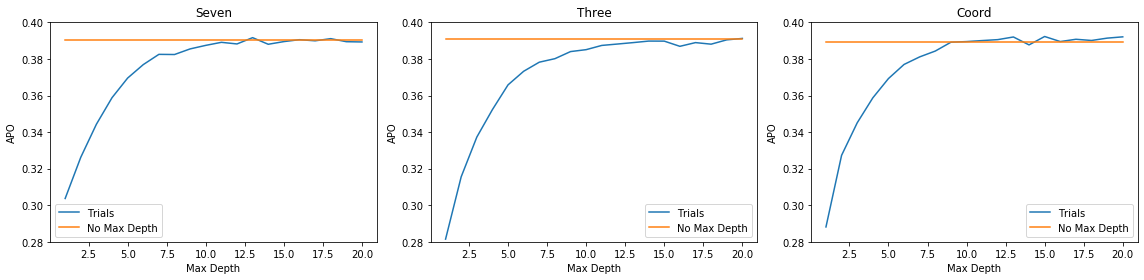

In [38]:
plt.subplots(1, 3, figsize=(16, 4))
for i in range(len(models)):
    plt.subplot(1, 3, i+1)
    plt.plot(depths[1:], Y[i][1:])
    plt.plot([depths[1], depths[-1]], [Y[i][0], Y[i][0]])
    plt.xlabel('Max Depth')
    plt.ylabel('APO')
    plt.ylim(0.28, 0.40)
    plt.title(models[i][1])
    plt.legend(labels = ['Trials', 'No Max Depth'])

plt.tight_layout()
plt.show()

## Number of Estimators (Trees)

In [107]:
results = pd.DataFrame(columns=['Model', 'Estimators'] + metric_names)
results

,Model,Estimators,Acc,Prec,Rec,F1,MCC,APO


In [108]:
models = ((std_dists, 'Seven', 11), (three_dists, 'Three', 14), (coords, 'Coord', 9))
num_trials = 1
est_nums = list(range(5, 105, 5))

for i in range(len(models)):
    for est_num in est_nums:
        rf = RandomForestClassifier(n_estimators=est_num)
        for j in range(num_trials):
            X_train, X_test, y_train, y_test = train_test_split(models[i][0], y, test_size=0.3)        
            rf.fit(X_train, y_train, sample_weight=df['Exp_Segment'].loc[X_train.index])
            y_pred = rf.predict(X_test)
            probs = pd.concat((y_test.reset_index(drop=True), pd.DataFrame(rf.predict_proba(X_test))), axis=1)
            schools = list(rf.classes_)
            metrics_list = [rf.score(X_test, y_test)]      
            metrics_list.extend(precision_recall_fscore_support(y_test, y_pred, average = 'macro')[:3])
            metrics_list.append(matthews_corrcoef(y_test, y_pred))
            metrics_list.append(probs.apply(lambda z: z[schools.index(z.School_Codes)], axis=1).mean())
            results.loc[len(results)] = [models[i][1], est_num] + metrics_list
results

Seven


C:\Users\ethan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Three
Coord


,Model,Estimators,Acc,Prec,Rec,F1,MCC,APO
0,Seven,5,0.450557,0.342275,0.300466,0.298538,0.238497,0.386506
1,Seven,10,0.451486,0.340157,0.298549,0.301237,0.236957,0.387844
2,Seven,15,0.457753,0.390097,0.308311,0.312920,0.247158,0.390949
3,Seven,20,0.455432,0.371731,0.313063,0.310573,0.248340,0.386661
4,Seven,25,0.465645,0.343443,0.320426,0.318961,0.254069,0.392938
5,Seven,30,0.460306,0.335572,0.319316,0.310889,0.252658,0.393076
6,Seven,35,0.475395,0.441887,0.321686,0.323164,0.268239,0.395002
7,Seven,40,0.454503,0.388115,0.308556,0.308117,0.248675,0.385487
8,Seven,45,0.469824,0.390528,0.317212,0.319929,0.259797,0.394586
9,Seven,50,0.459610,0.331775,0.310178,0.308155,0.249503,0.391032


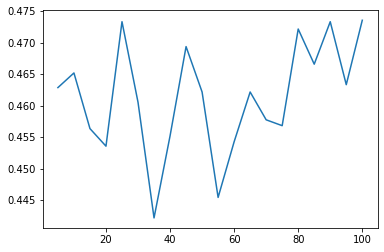

In [112]:
grouped = results[results['Model'] == 'Three'].groupby('Estimators').mean()
plt.plot(grouped.index, grouped['Acc'])

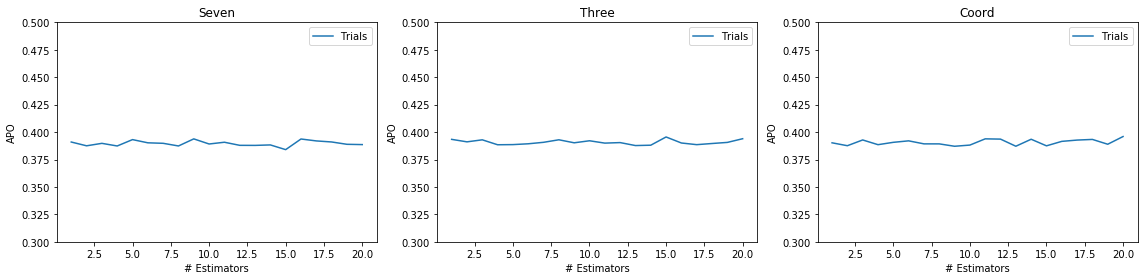

In [53]:
plt.subplots(1, 3, figsize=(16, 4))
for i in range(len(models)):
    plt.subplot(1, 3, i+1)
    plt.plot(est_nums, Y[i])
    #plt.plot([depths[1], depths[-1]], [Y[i][0], Y[i][0]])
    plt.xlabel('# Estimators')
    plt.ylabel('APO')
    plt.ylim(0.3, 0.5)
    plt.title(models[i][1])
    #plt.legend(labels = ['Trials', 'No Max Depth'])

plt.tight_layout()
plt.show()

## One Tree

In [79]:
rf = RandomForestClassifier(n_estimators=1)

X_train, X_test, y_train, y_test = train_test_split(models[i][0], y, test_size=0.3)        
rf.fit(X_train, y_train, sample_weight=df['Exp_Segment'].loc[X_train.index])
probs = pd.concat((y_test.reset_index(drop=True), pd.DataFrame(rf.predict_proba(X_test))), axis=1)
schools = list(rf.classes_)
# APOs.append(probs.apply(lambda z: z[schools.index(z.School_Codes)], axis=1).mean())
metrics_list = [rf.score(X_test, y_test)]      
metrics_list.extend(precision_recall_fscore_support(y_test, y_pred, average = 'macro')[:3])
metrics_list.append(matthews_corrcoef(y_test, y_pred))
metrics_list.append(probs.apply(lambda z: z[schools.index(z.School_Codes)], axis=1).mean())
metrics_list

[0.457288765088208,
 0.13172688999760762,
 0.14106426466135608,
 0.13360255794805512,
 -0.00518382475617274,
 0.40054387822705634]

In [77]:
(probs.astype(bool).sum(axis=1) - 1)

3    1208
4    1078
2     842
1     548
5     490
6     105
7      37
dtype: int64

## Min Leaf Size

See also:
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
- https://stackoverflow.com/questions/20463281/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn

In [115]:
models = ((std_dists, 'Seven'), (three_dists, 'Three'), (coords, 'Coord'))
num_trials = 3
leaf_sizes = list(range(1, 21))
Y = [[] for i in range(len(models))]

for i in range(len(models)):
    for leaf_size in leaf_sizes:
        rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=leaf_size)
        APOs = []
        for j in range(num_trials):
            X_train, X_test, y_train, y_test = train_test_split(models[i][0], y, test_size=0.3)        
            rf.fit(X_train, y_train, sample_weight=df['Exp_Segment'].loc[X_train.index])
            probs = pd.concat((y_test.reset_index(drop=True), pd.DataFrame(rf.predict_proba(X_test))), axis=1)
            schools = list(rf.classes_)
            APOs.append(probs.apply(lambda z: z[schools.index(z.School_Codes)], axis=1).mean())

        Y[i].append(average(APOs))

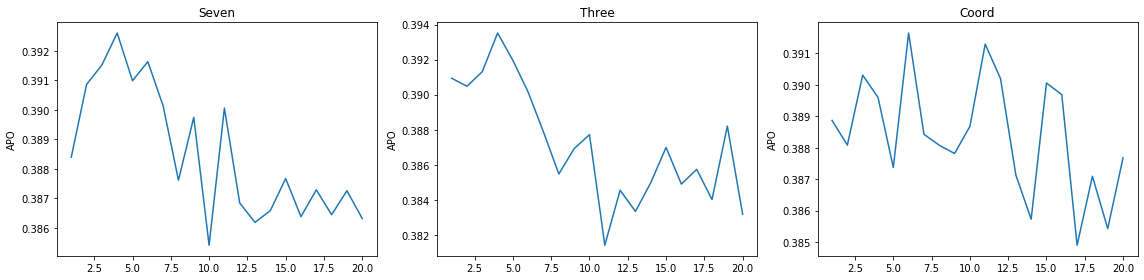

In [116]:
plt.subplots(1, 3, figsize=(16, 4))
for i in range(len(models)):
    plt.subplot(1, 3, i+1)
    plt.plot(leaf_sizes, Y[i])
    #plt.plot([depths[1], depths[-1]], [Y[i][0], Y[i][0]])
    #plt.xlabel('Max Depth')
    plt.ylabel('APO')
    #plt.ylim(0.28, 0.40)
    plt.title(models[i][1])
    #plt.legend(labels = ['Trials', 'No Max Depth'])

plt.tight_layout()
plt.show()